# Embedding workflow using DINOv2

This notebook focuses on the **Feature Extraction** pipeline. 

We utilize the fine-tuned model **ViTD2PC24All** ([DINOv2](https://dinov2.metademolab.com/)) to extract high-dimensional embeddings from the single-label train images and multi-label test images.

We'll **visualize**, **tile**, and **process** these embeddings to support patch-wise multi-label inference using PyTorch and Faiss.

![diagram](../images/pytorch-webinar-diagram.png)

In [2]:
%load_ext autoreload
%autoreload 2

## Now to load the parquet file from disk and visualize the images

In [3]:
import pandas as pd
from rich import print as pprint

pd.options.display.precision = 2
pd.options.display.max_rows = 10
pd.options.display.max_columns = 25

# root_dir = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025"
# dataset_dir = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/competition-metadata/PlantCLEF2025_test_images/PlantCLEF2025_test_images"
# hf_dataset_dir = "/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test/HF_dataset"
# dir(pd.options.display)

In [4]:
from datasets import Dataset as HFDataset, DatasetDict as HFDatasetDict
import os

from plantclef.pytorch.data import HFPlantDataset


data_subset_paths = {
    "train": "/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_308/train",
    "val": "/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_308/val",
    "test": "/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_308/test",
}

# data_subset_paths = {
#     "train": "/teamspace/studios/plantclef2025/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_308/train",
#     "val": "/teamspace/studios/plantclef2025/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_308/val",
#     "test": "/teamspace/studios/plantclef2025/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_308/test",
# }


data = HFDatasetDict(
    {
        "train": HFPlantDataset(data_subset_paths["train"], col_name="image").dataset,
        "val": HFPlantDataset(data_subset_paths["val"], col_name="image").dataset,
        "test": HFPlantDataset(data_subset_paths["test"], col_name="image").dataset,
    }
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_sdk/helpers.py:48: A newer version of lightning-sdk is available (0.2.14). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  0%|          | 0/40 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:00<00:04,  8.81it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

  5%|▌         | 2/40 [00:00<00:04,  8.62it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 10%|█         | 4/40 [00:00<00:03,  9.62it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 15%|█▌        | 6/40 [00:00<00:03,  9.74it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 18%|█▊        | 7/40 [00:00<00:03,  9.62it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 22%|██▎       | 9/40 [00:00<00:03,  9.54it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 25%|██▌       | 10/40 [00:01<00:03,  9.23it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 28%|██▊       | 11/40 [00:01<00:03,  9.32it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 32%|███▎      | 13/40 [00:01<00:02,  9.25it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 35%|███▌      | 14/40 [00:01<00:03,  7.98it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 38%|███▊      | 15/40 [00:01<00:03,  7.97it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 42%|████▎     | 17/40 [00:01<00:02,  9.65it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 48%|████▊     | 19/40 [00:01<00:01, 11.18it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 52%|█████▎    | 21/40 [00:02<00:01,  9.73it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 57%|█████▊    | 23/40 [00:02<00:01, 10.87it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 72%|███████▎  | 29/40 [00:02<00:00, 12.86it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 78%|███████▊  | 31/40 [00:20<00:24,  2.77s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 82%|████████▎ | 33/40 [00:35<00:31,  4.49s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 85%|████████▌ | 34/40 [00:46<00:34,  5.83s/it]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 88%|████████▊ | 35/40 [00:56<00:34,  6.97s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 90%|█████████ | 36/40 [01:06<00:30,  7.59s/it]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 92%|█████████▎| 37/40 [01:16<00:25,  8.43s/it]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

 95%|█████████▌| 38/40 [01:26<00:17,  8.82s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 98%|█████████▊| 39/40 [01:35<00:08,  8.85s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


In [5]:
data
# data['train'].take(3).map(lambda x: print(x.keys()))

DatasetDict({
    train: Dataset({
        features: ['image_path', 'label_idx', 'image_name', 'organ', 'species_id', 'obs_id', 'author', 'altitude', 'latitude', 'longitude', 'species', 'genus', 'family', 'learn_tag', '__index_level_0__', 'image'],
        num_rows: 1308899
    })
    val: Dataset({
        features: ['image_path', 'label_idx', 'image_name', 'organ', 'species_id', 'obs_id', 'author', 'altitude', 'latitude', 'longitude', 'species', 'genus', 'family', 'learn_tag', '__index_level_0__', 'image'],
        num_rows: 51194
    })
    test: Dataset({
        features: ['image_path', 'label_idx', 'image_name', 'organ', 'species_id', 'obs_id', 'author', 'altitude', 'latitude', 'longitude', 'species', 'genus', 'family', 'learn_tag', '__index_level_0__', 'image'],
        num_rows: 47940
    })
})

In [6]:
import torch
from tqdm import tqdm
from plantclef.pytorch.data import custom_collate_fn_partial
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import PIL.Image
from typing import List


# def get_transforms(is_training: bool = False) -> Callable:

#     tx = [
#         # A.Normalize(
#         #     mean=(0.5, 0.5, 0.5),
#         #     std=(0.5, 0.5, 0.5),
#         #     max_pixel_value=255.0
#         # )
#     ]

#     if is_training:
#         tx.extend(*[
#             A.RandomResizedCrop(
#                 size=(518, 518),
#                 scale=(0.08, 1.0),
#                 ratio=(0.75, 1.33),
#                 interpolation=cv2.INTER_LINEAR
#             ),
#             A.HorizontalFlip(),
#             A.VerticalFlip(),
#             # A.Normalize(
#             #     mean=(0.485, 0.456, 0.406),
#             #     std=(0.229, 0.224, 0.225)
#             # )
#             ])
#     else:
#         tx.extend([
#             A.Resize(518, 518),
#             A.CenterCrop(518, 518),
#             # A.Normalize(
#             #     mean=(0.485, 0.456, 0.406),
#             #     std=(0.229, 0.224, 0.225)
#             # )
#             ])
#     tx = A.Compose(tx, additional_targets=None)

#     def transform_func(image: List[PIL.Image.Image]) -> np.ndarray:
#         print(type(image))
#         print(len(image))
#         print(type(image[0]))
#         print(image[0].size)
#         image = np.array(image[0])
#         print(image.shape)
#         print(image.dtype)

#         image = tx(image=image)["image"]
#         return image
#     return transform_func


# tx = get_transforms(is_training=False)

In [1]:
from albumentations.pytorch import ToTensorV2

TARGET_SIZE = 518


def get_transforms():
    tx = A.Compose(
        [
            A.SmallestMaxSize(max_size=TARGET_SIZE, p=1.0),
            # Take a crop from the center
            A.CenterCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0),
            # Normalize using ImageNet presets
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # Convert to PyTorch tensor format
            ToTensorV2(),
        ],
        additional_targets=None,
    )

    def transform_func(image: List[PIL.Image.Image]) -> torch.Tensor:
        image = np.array(image[0])
        image = tx(image=image)["image"]
        return image

    return transform_func


tx = get_transforms()

NameError: name 'A' is not defined

In [33]:
dataset = data["val"]
# dataset.set_format(
#     type="torch",
#     columns=["image"],
#     device="cpu"
# )

dataset = dataset.with_transform(
    lambda x: {
        "image": tx(image=x["image"]),
        "label": x["label_idx"],
        "id": x["image_name"],
    }
)


img = dataset[1]["image"]

print(img.shape)

torch.Size([518, 518])


In [7]:
top_k = 5
batch_size = 16
device = "cpu"
cpu_count = os.cpu_count() or 1
use_grid = False


# model = DINOv2LightningModel(top_k=top_k)

# set device to GPU if available, otherwise CPU
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    collate_fn=custom_collate_fn_partial(use_grid, key="image"),
)

In [8]:
print("DataLoader created")
batch = next(iter(dataloader))

DataLoader created


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/teamspace/studios/this_studio/plantclef-vision/plantclef/pytorch/data.py", line 39, in collate_fn
    batch[key] = custom_collate_fn([b[key] for b in batch], use_grid)
  File "/teamspace/studios/this_studio/plantclef-vision/plantclef/pytorch/data.py", line 25, in custom_collate_fn
    return torch.stack(batch)  # shape: (B, C, H, W)
RuntimeError: stack expects each tensor to be equal size, but got [3, 415, 308] at entry 0 and [3, 410, 308] at entry 1


Compose(
    Resize(size=518, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(518, 518))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


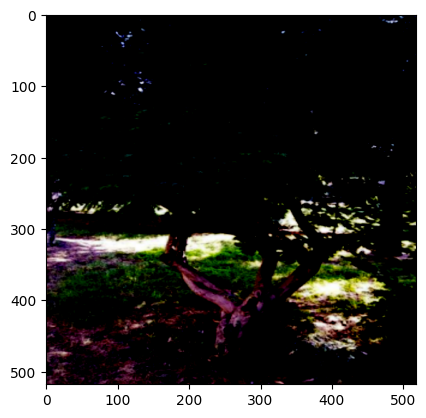

In [58]:
import matplotlib.pyplot as plt


# plt.imshow(norm_img)

In [11]:
# def transforms(examples):
#     examples["pixel_values"] = [
#         transform(image=np.array(image))["image"] for image in examples["image"]
#     ]

#     return examples

# dataset.transform = model.transform

# dataset.set_transform(transforms)

In [52]:
format_kwargs = {}

# dataset.set_format(
#     type="torch",
#     columns=["image"],
#     device=device
# )

dataset.set_format(type="numpy", columns=["image"])

In [49]:
dataset.features

{'image_path': Value(dtype='string', id=None),
 'label_idx': Value(dtype='int64', id=None),
 'image_name': Value(dtype='string', id=None),
 'organ': Value(dtype='string', id=None),
 'species_id': Value(dtype='int64', id=None),
 'obs_id': Value(dtype='int64', id=None),
 'author': Value(dtype='string', id=None),
 'altitude': Value(dtype='float64', id=None),
 'latitude': Value(dtype='float64', id=None),
 'longitude': Value(dtype='float64', id=None),
 'species': Value(dtype='string', id=None),
 'genus': Value(dtype='string', id=None),
 'family': Value(dtype='string', id=None),
 'learn_tag': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None)}

In [28]:
dataset.features

{'image_path': Value(dtype='string', id=None),
 'label_idx': Value(dtype='int64', id=None),
 'image_name': Value(dtype='string', id=None),
 'organ': Value(dtype='string', id=None),
 'species_id': Value(dtype='int64', id=None),
 'obs_id': Value(dtype='int64', id=None),
 'author': Value(dtype='string', id=None),
 'altitude': Value(dtype='float64', id=None),
 'latitude': Value(dtype='float64', id=None),
 'longitude': Value(dtype='float64', id=None),
 'species': Value(dtype='string', id=None),
 'genus': Value(dtype='string', id=None),
 'family': Value(dtype='string', id=None),
 'learn_tag': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None)}

In [53]:
img = dataset[0]["image"]

# tx_img = dataset.transform(img)

print(img.shape)
# print(tx_img.shape)

(415, 308, 3)


In [ ]:
# run inference and collect embeddings with tqdm progress bar
# all_embeddings = []
# all_logits = []
# for batch in tqdm(
#     dataloader, desc="Extracting embeddings and logits", unit="batch"
# ):
#     embeddings, logits = model.predict_grid_step(batch, batch_idx=0)
#     all_embeddings.append(embeddings.cpu())
#     # Each image in the batch gets a list of grid_size**2 dicts, each containing the top-k logits for that grid tile
#     all_logits.extend(logits)

# embeddings = torch.cat(all_embeddings, dim=0)  # shape: [len(df), grid_size**2, 768]

In [33]:
from plantclef.datasets.preprocessing.hf.train_val_test_subsets_to_hf import (
    # Config,
    preprocess_hf_dataset,
    # HFDataset,
)
from plantclef.utils.imutils import ImageProcessor
from plantclef.datasets.preprocessing.hf.parallel_utils import (
    # ImageProcessor,
    ResizeDatasetConfig,
)


# cfg = Config()
# cfg = ResizeDatasetConfig()
# cfg.data_cfg.show()

### scratch attempt at loading shards

In [34]:
# full_train_dataset_path = "/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_256/train/"

# shard_paths = [
#     os.path.join(full_train_dataset_path, p)
#     for p in os.listdir(full_train_dataset_path)
#     if p.endswith(".arrow")
# ]

# ds = concatenate_datasets([HFDataset.load_from_disk(p) for p in tqdm(shard_paths)])

In [35]:
func_args = {
    "image_size": {"shortest_edge": 256},
    "log_dir": "~/resize_dataset_logs",
    "kwargs": {
        "batch_size": 32,
        "num_samples_per_shard": 32768,
        "interpolation_mode": "BILINEAR",
    },
}

In [36]:
kwargs = func_args.pop("kwargs")
cfg = ResizeDatasetConfig(**func_args, **kwargs)


dataset_subsets = preprocess_hf_dataset(cfg.data_cfg)
ds = dataset_subsets["train"]

cfg.set_subset("train")
cfg.set_dataset(ds)

cfg.show()

{'shortest_edge': 256}
[Cache Found] previously preprocessed metadata cache, loading from cache file and skipping preprocessing


ResizeDatasetConfig(
    num_samples=1308899,
    num_shards=40,
    num_batches_per_shard=1024,
    num_samples_per_shard=32768,
    batch_size=32,
    interpolation_mode='BILINEAR',
    image_size={'shortest_edge': 256},
    log_dir='/teamspace/studios/this_studio/resize_dataset_logs'
)

In [41]:
# cfg.show()
32768 / 264

(1308899 / 124) / 60

175.92728494623654

In [21]:
cfg.__dataclass_fields__
cfg_dict = cfg.data_cfg.to_dict()
new_cfg = type(cfg.data_cfg).from_dict(cfg_dict)

new_cfg.show()

{}

In [14]:
new_cfg.to_dict()

{'name': 'train_val_test',
 'x_col': 'image_path',
 'label_col': 'species_id',
 'target_col': 'label_idx',
 'image_size': {'shortest_edge': 588},
 'interpolation_mode': 'BILINEAR',
 'dataset_dir': '/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800',
 'metadata_cache_path': '/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/competition-metadata/PlantCLEF2024_single_plant_training_metadata.parquet',
 'hf_datasets_root_dir': '/teamspace/studios/this_studio/plantclef-vision/data/hf',
 'hf_dataset_dir': '/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test',
 '_hf_dataset_path': '/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_588'}

In [3]:
from math import ceil

# with open(os.path.expanduser("~/.temp_file.json"), "w") as f:
#     f.write(json.dump(asdict(cfg.data_cfg), f))

num_samples_per_shard: 8181
num_batches_per_shard: 128


In [ ]:
# num_samples = 1308899
# num_shards = 160
# batch_size = 64

# num_samples_per_shard = ceil(num_samples / num_shards)

# num_batches_per_shard = ceil(num_samples_per_shard / batch_size)

# print(f"num_samples_per_shard: {num_samples_per_shard}")
# print(f"num_batches_per_shard: {num_batches_per_shard}")

num_samples = 1308899
num_samples_per_shard = 4096

num_shards = ceil(num_samples / num_samples_per_shard)
batch_size = 64

num_batches_per_shard = ceil(num_samples_per_shard / batch_size)

print(f"num_samples: {num_samples}")
print(f"num_shards: {num_shards}")
print(f"num_samples_per_shard: {num_samples_per_shard}")
print(f"num_batches_per_shard: {num_batches_per_shard}")

In [5]:
num_samples / num_shards

8180.61875

In [ ]:
# dataset_subsets = preprocess_hf_dataset(cfg.data_cfg)
# ds = dataset_subsets["train"]
# dataset_features = ds.features
# b = ds.take(100).batch(10)[0]
# shard = HFDataset.from_dict(b, features=dataset_features)

# shard
# for k, v in shard.features.items():
#     assert (
#         dataset_features[k] == v
#     ), f"Feature mismatch for {k}: {dataset_features[k]} != {v}"
# examine_ds = ds.take(131072)

In [19]:
# df = examine_ds.to_pandas()
# df.describe(include="all")

In [ ]:
# import PIL.Image
# from tqdm import trange
# sizes = []
# paths = []
# imgs = []

# for i in trange(63232, 63232+128):
#     path = df.iloc[i]["image_path"]
#     paths.append(path)

#     img = PIL.Image.open(path)
#     sizes.append(img.size)
#     img.load()
#     imgs.append(img)


# print(sizes)


100%|██████████| 128/128 [00:00<00:00, 292.37it/s]

[(599, 800), (600, 800), (601, 800), (600, 800), (600, 800), (800, 600), (400, 800), (600, 800), (600, 800), (800, 800), (600, 800), (600, 800), (599, 800), (600, 800), (800, 579), (600, 800), (601, 800), (600, 800), (800, 541), (600, 800), (600, 800), (480, 800), (600, 800), (450, 800), (800, 533), (455, 800), (600, 800), (800, 389), (600, 800), (729, 800), (800, 600), (451, 800), (600, 800), (600, 800), (600, 800), (600, 800), (800, 600), (600, 800), (800, 600), (450, 800), (600, 800), (451, 800), (600, 800), (451, 800), (800, 600), (800, 600), (600, 800), (600, 800), (600, 800), (800, 800), (403, 800), (600, 800), (800, 450), (800, 606), (600, 800), (800, 600), (600, 800), (369, 800), (600, 800), (600, 800), (600, 800), (600, 800), (533, 800), (800, 600), (800, 713), (565, 800), (800, 600), (600, 800), (600, 800), (600, 800), (800, 532), (800, 536), (736, 800), (558, 800), (600, 800), (600, 800), (600, 800), (600, 800), (450, 800), (600, 800), (450, 800), (450, 800), (400, 800), (60

In [28]:
debug_dataset_path = "/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_350/debug"

ds = HFDataset.load_from_disk(debug_dataset_path)
df = ds.to_pandas()
df.describe(include="all")

,image_path,label_idx,image_name,organ,species_id,obs_id,author,altitude,latitude,longitude,species,genus,family,learn_tag,__index_level_0__
count,6144,6144.00,6144,6144,6.14e+03,6.14e+03,6144,3892.00,3893.00,3893.00,6144,6144,6144,6144,6144.00
unique,6144,NaN,6144,7,NaN,NaN,3806,NaN,NaN,NaN,83,60,29,1,NaN
top,/teamspace/studios/this_studio/plantclef-visio...,NaN,47c2104a44039b98c3a12a493a67d3b1ed73b9b6.jpg,flower,NaN,NaN,Tela Botanica − Liliane Roubaudi,NaN,NaN,NaN,Robinia pseudoacacia L.,Robinia,Fabaceae,train,NaN
freq,1,NaN,1,2051,NaN,NaN,114,NaN,NaN,NaN,590,590,899,6144,NaN
mean,NaN,2950.86,NaN,NaN,1.39e+06,1.01e+09,NaN,335.62,42.73,2.12,NaN,NaN,NaN,NaN,112724.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,NaN,137.00,NaN,NaN,1.36e+06,1.00e+09,NaN,-87.60,-46.90,-124.32,NaN,NaN,NaN,NaN,84885.00
25%,NaN,1012.00,NaN,NaN,1.36e+06,1.01e+09,NaN,60.33,41.64,-0.57,NaN,NaN,NaN,NaN,86489.75
50%,NaN,2531.00,NaN,NaN,1.36e+06,1.01e+09,NaN,161.85,43.72,3.88,NaN,NaN,NaN,NaN,120632.50
75%,NaN,4777.00,NaN,NaN,1.40e+06,1.02e+09,NaN,409.70,48.70,9.20,NaN,NaN,NaN,NaN,131033.25


In [43]:
(((3 * 60) + 40 + 24) * 40) // 60
65536 + 63232

128768

6144it [00:33, 183.53it/s]


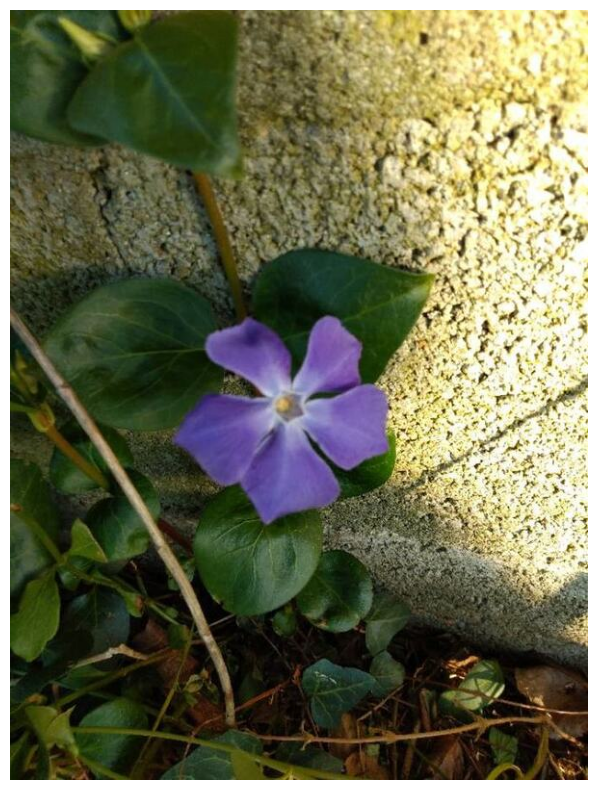

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sizes = []

for i, row in tqdm(df.iterrows()):
    path = row["image_path"]
    img = PIL.Image.open(path)
    img.load()
    # print(img.size)
    sizes.append(img.size)
    plt.imshow(img)
    plt.axis("off")
    # plt.show()
    # img.show()
    # if i > 100:
    #     break

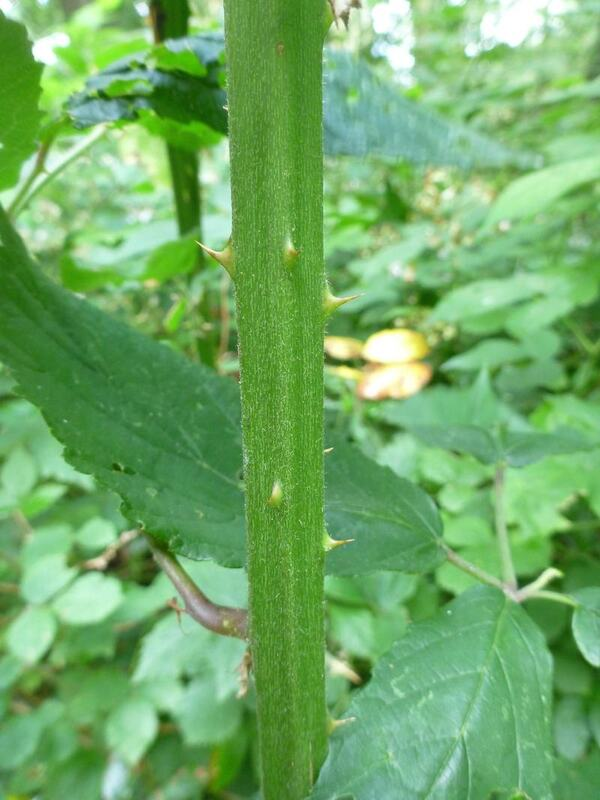

In [34]:
img

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image_path         6144 non-null   object 
 1   label_idx          6144 non-null   int64  
 2   image_name         6144 non-null   object 
 3   organ              6144 non-null   object 
 4   species_id         6144 non-null   int64  
 5   obs_id             6144 non-null   int64  
 6   author             6144 non-null   object 
 7   altitude           3892 non-null   float64
 8   latitude           3893 non-null   float64
 9   longitude          3893 non-null   float64
 10  species            6144 non-null   object 
 11  genus              6144 non-null   object 
 12  family             6144 non-null   object 
 13  learn_tag          6144 non-null   object 
 14  __index_level_0__  6144 non-null   int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 720.1+ KB


In [26]:
os.makedirs(
    "/teamspace/studios/this_studio/plantclef-vision/data/hf/plantclef2025/single_label_train_val_test/shortest_edge_350/debug",
    exist_ok=True,
)

In [ ]:
# num_batches_per_shard = 4
# batch_size = 16  # 256
# shard_size = batch_size * 4
# resume_from_shard = cfg.get_last_existing_shard_idx()  # Gets the index of the last shard written to cfg.hf_dataset_path, else returns 0 to start from beginning

# shard_idx = resume_from_shard or 0


# dataset_subsets = preprocess_hf_dataset(cfg)
# ds = dataset_subsets["train"]

# shards = ds.batch(shard_size).skip(shard_idx)

# total_size = len(ds)
# num_proc = os.cpu_count()
# num_shards = total_size // shard_size + 1

# process_batch = ImageProcessor(
#     image_size={"shortest_edge": 588}, interpolation_mode="BILINEAR"
# ).process_batch_with_key

# process_func = partial(process_batch, key="image_path")

# for shard in tqdm(shards):
#     shard = HFDataset.from_dict(shard)

#     processed_shard = shard.map(
#         process_func,
#         input_columns=cfg.x_col,
#         batched=True,
#         batch_size=batch_size,
#         num_proc=num_proc,
#         desc=f"Processing shard {shard_idx} of {num_shards}",
#     )

#     processed_shard = processed_shard.rename_column(cfg.x_col, "image")
#     processed_shard = processed_shard.cast_column("image", Image())

#     shard_path = cfg.get_shard_path(shard_idx, shard_size, total_size)

#     processed_shard.save_to_disk(shard_path)

#     shard_idx += 1
#     break

In [2]:
256 * 5113 / (500 * 32)

81.808

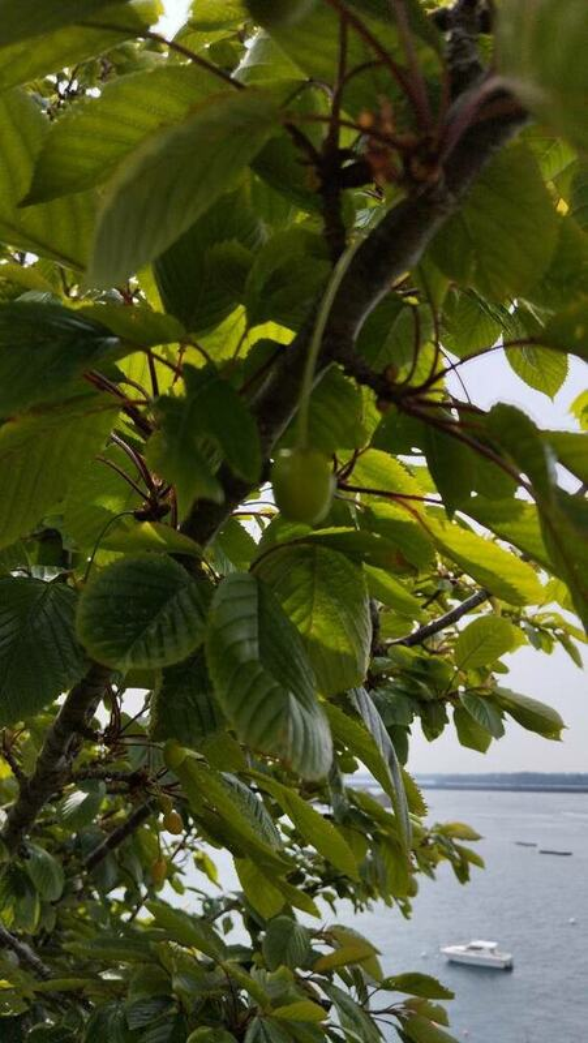

In [35]:
# processed_shard[45]["image_path"]

In [18]:
# image_path = shard[0]["image_path"]


img_processor = ImageProcessor(
    image_size={"shortest_edge": 588}, interpolation_mode="BILINEAR"
)

# img = img_processor.read_image(image_path)
# resized_img = img_processor.resize_image(img)

In [122]:
import os


# def measure_image(image_path):
#     with PIL.Image.open(image_path) as img:
#         width, height = img.size
#     return {"width": width, "height": height}

(600, 800)

In [60]:
# from tqdm import tqdm
# batches_ds_list = [HFDataset.from_dict(b) for b in tqdm(batches.take(10))]
# batches_ds = concatenate_datasets(batches_ds_list)
# from datasets import Dataset as HFDataset, Image
# import os

# batch = HFDataset.from_dict(batches[0])
# batch


# tx = get_dict_transform(
#     transform_kwargs={"image_size": {"shortest_edge": 716}}, input_columns=cfg.x_col
# )

# # print(f"[INITIATING dataset.map(resize)] -- using num_proc={os.cpu_count()}")
# batch = batch.cast_column(cfg.x_col, Image())
# batch = batch.map(tx, input_columns=cfg.x_col, num_proc=os.cpu_count())

{'examples_iterable': {'shard_idx': 0,
  'shard_example_idx': 0,
  'type': 'ArrowExamplesIterable'},
 'epoch': 0}

In [29]:
# val_ds.features

{'image_path': Value(dtype='string', id=None),
 'label_idx': Value(dtype='int64', id=None),
 'image_name': Value(dtype='string', id=None),
 'organ': Value(dtype='string', id=None),
 'species_id': Value(dtype='int64', id=None),
 'obs_id': Value(dtype='int64', id=None),
 'author': Value(dtype='string', id=None),
 'altitude': Value(dtype='float64', id=None),
 'latitude': Value(dtype='float64', id=None),
 'longitude': Value(dtype='float64', id=None),
 'species': Value(dtype='string', id=None),
 'genus': Value(dtype='string', id=None),
 'family': Value(dtype='string', id=None),
 'learn_tag': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [31]:
# val_ds.take(10)["__index_level_0__"]
# ds = HFDataset.from_dict({"image": image_paths, "file_path": image_paths})
# ds = ds.cast_column("image", Image())
# ds = ds.cast_column("file_path", Value("string"))
# metadata.info(verbose=True)
# metadata[keep_cols].info(verbose=True)
# metadata["gbif_species_id"].nunique()
# metadata["species_id"].nunique()

# metadata["gbif_species_id"].isna().sum()
# metadata["species_id"].isna().sum()
# metadata.head(3)
# metadata.describe(include="all")`

[479, 489, 490, 491, 492, 493, 495, 496, 497, 498]

## Running torch_pipeline with HFPlantDataset

In [6]:
from plantclef.embed.workflow import Config
from plantclef.embed.utils import print_dir_size
import os

cfg = Config()
pprint(cfg)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_sdk/helpers.py:48: UserWarning: A newer version of lightning-sdk is available (0.2.14). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  warnings.warn(


Config(
    use_grid=True,
    grid_size=3,
    image_size=546,
    batch_size=16,
    cpu_count=4,
    top_k=5,
    device='cpu',
    root_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025',
    dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/competition-metadata/PlantCLEF2
025_test_images/PlantCLEF2025_test_images',
    hf_dataset_dir='/teamspace/studios/this_studio/plantclef-vision/data/parquet/plantclef2025/full_test/HF_dataset
',
    embeddings_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings',
    test_embeddings_dir='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test',
    folder_name='test_grid_3x3_embeddings',
    test_embeddings_path='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/t
est_grid_3x3_embeddings',
    test_submission_path='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/t
est_grid_3x3_embeddings-submission.csv',
    config_path='/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_
3x3_embeddings-config.json'
)

In [14]:
import csv
import pandas as pd


df = pd.read_csv(cfg.test_submission_path)

df = df.assign(quadrat_id=df["quadrat_id"].apply(lambda x: os.path.splitext(x)[0]))

df.to_csv(cfg.test_submission_path, sep=",", index=False, quoting=csv.QUOTE_ALL)
df

,quadrat_id,species_ids
0,2024-CEV3-20240602,"[1654010, 1395063, 1392662, 1414387, 1743646]"
1,CBN-PdlC-A1-20130807,"[1744569, 1361917, 1356350, 1418612, 1361129]"
2,CBN-PdlC-A1-20130903,"[1744569, 1392608, 1361382, 1361068, 1361971]"
3,CBN-PdlC-A1-20140721,"[1529289, 1374758, 1402995, 1741880, 1362066]"
4,CBN-PdlC-A1-20140811,"[1361281, 1418612, 1356350, 1392608, 1722440]"
...,...,...
2100,RNNB-8-5-20240118,"[1361437, 1655199, 1357049, 1722441, 1414356]"
2101,RNNB-8-6-20240118,"[1655199, 1363434, 1359297, 1357962, 1361703]"
2102,RNNB-8-7-20240118,"[1359297, 1356521, 1363553, 1357358, 1362711]"
2103,RNNB-8-8-20240118,"[1359650, 1396330, 1743962, 1357962, 1388788]"


In [5]:
print_dir_size(cfg.test_embeddings_path)

Analyzing disk usage of directory: /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_3x3_embeddings
Directory Disk Usage: 543M	/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_3x3_embeddings
2025-05-08 08:42:53


In [22]:
# top_1 = []
# top_2 = []
# top_3 = []
# top_4 = []
# top_5 = []

# for i, row in df.iterrows():
#     top_1.append(row["logits"][0])
#     top_2.append(row["logits"][1])
#     top_3.append(row["logits"][2])
#     top_4.append(row["logits"][3])
#     top_5.append(row["logits"][4])

#     print(i)
#     # pprint(row)

#     if i >= 5:
#         break

# print(f"top_1: {top_1}")
# print(f"top_2: {top_2}")
# print(f"top_3: {top_3}")
# print(f"top_4: {top_4}")
# print(f"top_5: {top_5}")
# top_species_ids = [s_id for s_id, _ in [*top_1, *top_2, *top_3, *top_4, *top_5]]

/tmp/ipykernel_33614/1293469598.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.apply(select_top_k_unique_logits, top_k=top_k).rename("logits").reset_index()


,image_name,logits
0,2024-CEV3-20240602.jpg,"[(1654010, 0.44266772270202637), (1395063, 0.3..."
1,CBN-PdlC-A1-20130807.jpg,"[(1744569, 0.2301855832338333), (1361917, 0.22..."
2,CBN-PdlC-A1-20130903.jpg,"[(1744569, 0.16917195916175842), (1392608, 0.1..."
3,CBN-PdlC-A1-20140721.jpg,"[(1529289, 0.14910352230072021), (1374758, 0.1..."
4,CBN-PdlC-A1-20140811.jpg,"[(1361281, 0.12936192750930786), (1418612, 0.1..."
...,...,...
2100,RNNB-8-5-20240118.jpg,"[(1361437, 0.7179210782051086), (1655199, 0.52..."
2101,RNNB-8-6-20240118.jpg,"[(1655199, 0.37736761569976807), (1363434, 0.2..."
2102,RNNB-8-7-20240118.jpg,"[(1359297, 0.30361855030059814), (1356521, 0.2..."
2103,RNNB-8-8-20240118.jpg,"[(1359650, 0.3005388379096985), (1396330, 0.28..."


## Explore embeddings

### Get embeddings and logits from model.predict_step

### Get image names from HFDataset -> Create a pandas DataFrame to match image names to logits + embeddings

# Misc below

### Extracting embeddings from single-label training images

We extract embeddings from a small subset of training images to validate our pipeline.  
We don't perform tiling on the train images (we use the full image) and extract 768-dimensional ViT embeddings.

### Embedding test images with tiling (3x3)


Since the test images are high-resolution and contain multiple plant species, we split them into a 3x3 grid of tiles.
- We **extract embeddings** and **top-*K* logits** from each tile using the ViT model.  
- This **patch-wise representation** is critical for enabling multi-label classification.

### Analyzing classifier logits per tile

For each tile, we look at the **top predicted species** and associated confidence scores (`logits`).  
This helps interpret how confident the model is in identifying species in each patch.

### Embedding the entire test set with tiling

We scale up our embedding pipeline to process the full test dataset using **3x3 tiling**.  
This prepares the data for the downstream tasks of efficient **nearest neighbor search** and **multi-label prediction** at the tile level.

### Saving test embeddings and logits to Parquet

We serialize the full test embeddings into partitioned Parquet files for later use in inference pipelines.  
The logits are stored as JSON strings for flexibility.

## Embedding the full training set (no tiling)

We repeat the embedding process on the **full training dataset**, this time *without tiling*.  
This enables us to use the embeddings directly or as a **transfer learning** approach in a Faiss-based nearest neighbor retrieval system.

### Saving the training embeddings to Parquet

Finally, we save the full training embeddings in partitioned Parquet format to support fast, distributed retrieval during inference.

### Embeddings Ready for Downstream Use

We now have rich ViT embeddings for both train and test datasets, ready for use in:
- Multi-label classification
- Retrieval-based inference
- Nearest Neighbor Search